##  Part 1: Setup

The first step is to setup up the required modules. We imported tensorflow_datasets to train on ImageNet-1k.You can run the following code in the bash:

```bash
pip install tensorflow_datasets


In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('Using GPU(0):', physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
else:
    print('Using CPU')

import numpy as np
from numpy.random import shuffle
import time
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline

# Notebook auto reload code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2
print(tf.__version__)

Using GPU(0): PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.4.0


##  Part 2: Load and Preprocess ImageNet-1k

In [2]:
import tensorflow as tf
import os
import shutil

data_dir = "tiny-imagenet-10"  # Folder name after extraction

# Get the list of all class directories in the training set
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [4]:
import shutil

# Define preprocessing
IMG_SIZE = 224  # Resize all images to 224x224
BATCH_SIZE = 8

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Load the datasets
# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',  # Labels are integers
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


Found 5000 files belonging to 10 classes.


In [5]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Test Dataset (if test labels exist)
# If no labels, use label_mode=None
try:
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        label_mode=None,  # Set None if labels are not available
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=False
    ).map(lambda x: tf.image.resize(x, [IMG_SIZE, IMG_SIZE]) / 255.0, 
          num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
except Exception as e:
    test_ds = None
    print(f"No test dataset found: {e}")

# Check dataset shapes
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)
for images, labels in val_ds.take(1):
    print("Validation batch shape:", images.shape, labels.shape)

if test_ds:
    for images in test_ds.take(1):
        print("Test batch shape:", images.shape)

Found 500 files belonging to 10 classes.
No test dataset found: name 'test_dir' is not defined
Train batch shape: (8, 224, 224, 3) (8,)
Validation batch shape: (8, 224, 224, 3) (8,)


##  Part 3: Develop the Model

The key part of our project is the ConvMixer model.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same"),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    # Build the model
    return Sequential(layers_list)

Now, we can setup our model.

In [ ]:
from utils.ConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 9
patch_size = 14
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 16, 16, 512)       301568    
_________________________________________________________________
activation_85 (Activation)   (None, 16, 16, 512)       0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 16, 16, 512)       2048      
_________________________________________________________________
sequential_86 (Sequential)   (None, 16, 16, 512)       308736    
_________________________________________________________________
sequential_88 (Sequential)   (None, 16, 16, 512)       308736    
_________________________________________________________________
sequential_90 (Sequential)   (None, 16, 16, 512)       308736    
_________________________________________________________________
sequential_92 (Sequential)   (None, 16, 16, 512)    

##  Part 4: Compile the Model

Configure the optimizer, loss function, and metrics for training:

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

##  Part 5: Train the Model

In [34]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")


In [35]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 45s 67ms/step - loss: 2.2865 - sparse_categorical_accuracy: 0.2215 - val_loss: 2.0900 - val_sparse_categorical_accuracy: 0.3300
Epoch 1 time: 45.13 seconds
Epoch 2/15
625/625 [==============================] - 41s 66ms/step - loss: 1.7939 - sparse_categorical_accuracy: 0.3780 - val_loss: 1.7113 - val_sparse_categorical_accuracy: 0.4260
Epoch 2 time: 41.46 seconds
Epoch 3/15
625/625 [==============================] - 42s 66ms/step - loss: 1.6237 - sparse_categorical_accuracy: 0.4351 - val_loss: 1.6168 - val_sparse_categorical_accuracy: 0.4420
Epoch 3 time: 41.53 seconds
Epoch 4/15
625/625 [==============================] - 42s 66ms/step - loss: 1.4980 - sparse_categorical_accuracy: 0.4846 - val_loss: 1.6084 - val_sparse_categorical_accuracy: 0.4800
Epoch 4 time: 41.54 seconds
Epoch 5/15
625/625 [==============================] - 42s 66ms/step - loss: 1.3753 - sparse_categorical_accuracy: 0.5287 - val_loss: 1.4829 - val_sparse_categor

##  Part 6: Validate the Model

In [36]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 1s 15ms/step - loss: 1.9088 - sparse_categorical_accuracy: 0.5740
Validation Loss: 1.9088
Validation Accuracy: 57.4000%


Plot training and validation accuracy/loss over epochs:

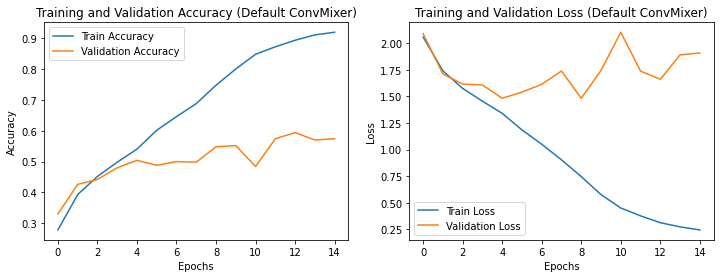

In [37]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Default ConvMixer)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Default ConvMixer)')

plt.show()

## Other Patch Values

In [ ]:
from utils.ConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 9
patch_size = 4
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 56, 56, 512)       25088     
_________________________________________________________________
activation_102 (Activation)  (None, 56, 56, 512)       0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 56, 56, 512)       2048      
_________________________________________________________________
sequential_103 (Sequential)  (None, 56, 56, 512)       308736    
_________________________________________________________________
sequential_105 (Sequential)  (None, 56, 56, 512)       308736    
_________________________________________________________________
sequential_107 (Sequential)  (None, 56, 56, 512)       308736    
_________________________________________________________________
sequential_109 (Sequential)  (None, 56, 56, 512)    

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [40]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")


In [41]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 513s 816ms/step - loss: 2.1459 - sparse_categorical_accuracy: 0.2628 - val_loss: 2.1123 - val_sparse_categorical_accuracy: 0.3020
Epoch 1 time: 513.17 seconds
Epoch 2/15
625/625 [==============================] - 510s 816ms/step - loss: 1.7405 - sparse_categorical_accuracy: 0.4029 - val_loss: 1.7535 - val_sparse_categorical_accuracy: 0.4640
Epoch 2 time: 510.06 seconds
Epoch 3/15
625/625 [==============================] - 511s 817ms/step - loss: 1.4981 - sparse_categorical_accuracy: 0.4834 - val_loss: 2.3106 - val_sparse_categorical_accuracy: 0.4720
Epoch 3 time: 510.53 seconds
Epoch 4/15
625/625 [==============================] - 510s 816ms/step - loss: 1.3292 - sparse_categorical_accuracy: 0.5532 - val_loss: 1.2719 - val_sparse_categorical_accuracy: 0.5840
Epoch 4 time: 509.95 seconds
Epoch 5/15
625/625 [==============================] - 510s 816ms/step - loss: 1.2097 - sparse_categorical_accuracy: 0.5993 - val_loss: 1.4484 - val_

##  Validate the Model

In [42]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 10s 153ms/step - loss: 1.5130 - sparse_categorical_accuracy: 0.6720
Validation Loss: 1.5130
Validation Accuracy: 67.2000%


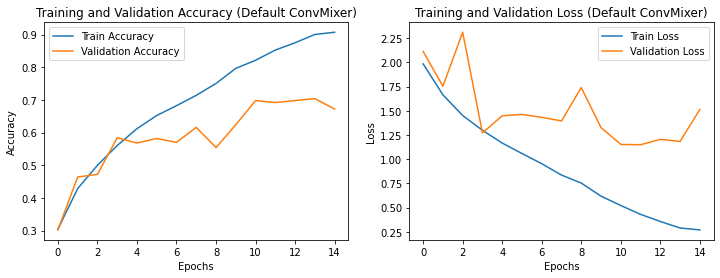

In [43]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Default ConvMixer)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Default ConvMixer)')

plt.show()

## Patch = 11

In [ ]:
from utils.ConvMixer import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 9
patch_size = 11
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 20, 20, 512)       186368    
_________________________________________________________________
activation_68 (Activation)   (None, 20, 20, 512)       0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 20, 20, 512)       2048      
_________________________________________________________________
sequential_69 (Sequential)   (None, 20, 20, 512)       308736    
_________________________________________________________________
sequential_71 (Sequential)   (None, 20, 20, 512)       308736    
_________________________________________________________________
sequential_73 (Sequential)   (None, 20, 20, 512)       308736    
_________________________________________________________________
sequential_75 (Sequential)   (None, 20, 20, 512)     

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [28]:
import tensorflow as tf
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        print(f"Total training time: {total_time:.2f} seconds")

In [29]:
# Train the ConvMixer model
EPOCHS = 15
time_callback = TimeHistory()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/15
625/625 [==============================] - 66s 101ms/step - loss: 2.2515 - sparse_categorical_accuracy: 0.2454 - val_loss: 2.3607 - val_sparse_categorical_accuracy: 0.3440
Epoch 1 time: 66.11 seconds
Epoch 2/15
625/625 [==============================] - 62s 100ms/step - loss: 1.7276 - sparse_categorical_accuracy: 0.3985 - val_loss: 1.9453 - val_sparse_categorical_accuracy: 0.4160
Epoch 2 time: 62.25 seconds
Epoch 3/15
625/625 [==============================] - 62s 100ms/step - loss: 1.5934 - sparse_categorical_accuracy: 0.4576 - val_loss: 1.6722 - val_sparse_categorical_accuracy: 0.4700
Epoch 3 time: 62.33 seconds
Epoch 4/15
625/625 [==============================] - 62s 100ms/step - loss: 1.4448 - sparse_categorical_accuracy: 0.5091 - val_loss: 1.5378 - val_sparse_categorical_accuracy: 0.4880
Epoch 4 time: 62.29 seconds
Epoch 5/15
625/625 [==============================] - 62s 100ms/step - loss: 1.3249 - sparse_categorical_accuracy: 0.5505 - val_loss: 1.5009 - val_sparse_ca

In [30]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 [==============================] - 1s 19ms/step - loss: 1.5425 - sparse_categorical_accuracy: 0.6340
Validation Loss: 1.5425
Validation Accuracy: 63.4000%


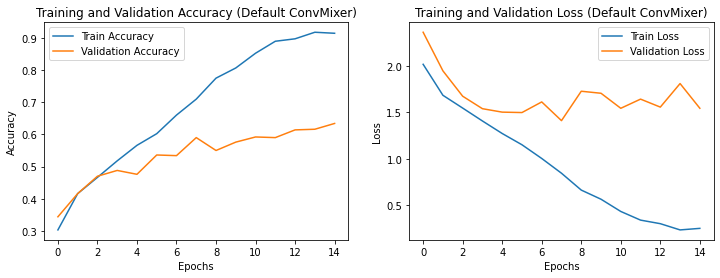

In [31]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Default ConvMixer)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Default ConvMixer)')

plt.show()